# 1.) Import the data from CCLE into a new Google Colab file

In [28]:
import numpy as np
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt

In [29]:
drive.mount('/content/gdrive/', force_remount = True)

Mounted at /content/gdrive/


In [30]:
insurance = pd.read_csv('/content/gdrive/MyDrive/441B/insurance.csv')

In [31]:
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [32]:
# Data Cleaning: Dummy Variable
from sklearn.preprocessing import LabelEncoder

In [33]:
def dummy(x):
  encoder = LabelEncoder().fit(insurance[x])
  insurance[x] = encoder.transform(insurance[x])

In [34]:
dummy_list = ['sex', 'smoker', 'region']
for x in dummy_list:
  dummy(x)

In [35]:
insurance.head()
# 'sex' = 0, female
# 'smoker' = 0, no
# 'region' = 0, northeast;  = 1, northwest; = 2, southeast; = 3, southwest

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


# 2.) Split the data into 80/20, in/out sample

In [36]:
# seperate data(predictors) and target
data = np.array(insurance.iloc[:, :6])
target = np.array(insurance.iloc[:, -1])

In [37]:
# 80/20
cut = int(len(data) * .8) // 1

In [38]:
in_data = data[ : cut]
out_data = data[cut : ]
in_target = target[ : cut]
out_target = target[cut : ]

In [39]:
in_data

array([[19.   ,  0.   , 27.9  ,  0.   ,  1.   ,  3.   ],
       [18.   ,  1.   , 33.77 ,  1.   ,  0.   ,  2.   ],
       [28.   ,  1.   , 33.   ,  3.   ,  0.   ,  2.   ],
       ...,
       [39.   ,  1.   , 42.655,  0.   ,  0.   ,  0.   ],
       [63.   ,  1.   , 21.66 ,  1.   ,  0.   ,  1.   ],
       [54.   ,  0.   , 31.9  ,  1.   ,  0.   ,  2.   ]])

# 3.) Normalize the Data

In [40]:
from sklearn import preprocessing

In [41]:
scaler = preprocessing.StandardScaler().fit(in_data) # model
in_data_scale = scaler.transform(in_data)
out_data_scale = scaler.transform(out_data)

# 4.) Get lambda from Lasso cross validation

In [42]:
from sklearn.linear_model import LassoCV

In [43]:
modCV = LassoCV().fit(in_data_scale, in_target)
a = modCV.alpha_ # optimize Lambda

In [44]:
print('The optimal Lambda is ', a)

The optimal Lambda is  133.34880015958146


# 5.) Run a lambda regression with that Lambda

In [45]:
from sklearn.linear_model import Lasso
mod = Lasso(alpha = a).fit(in_data_scale, in_target)
mod.coef_

array([3564.26137833,   -0.        , 1890.8527485 ,  398.24050447,
       9324.84227138, -326.52198757])

# 6.) Visualize the coefficients 

In [46]:
features = insurance.columns[:6]

In [47]:
coef = pd.Series(mod.coef_, index = features).sort_values(ascending = False)
coef

smoker      9324.842271
age         3564.261378
bmi         1890.852749
children     398.240504
sex           -0.000000
region      -326.521988
dtype: float64

Text(0.5, 1.0, 'Coefficients From the Lasso Model')

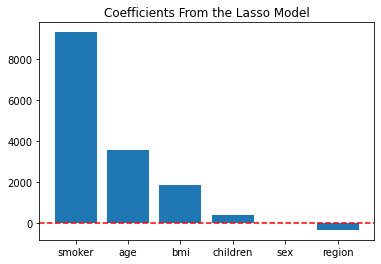

In [48]:
plt.bar(coef.index, coef.values)
plt.axhline(y =0, c = 'red', ls = '--')
plt.title('Coefficients From the Lasso Model')

# 7.) Interpret the coefficients

The coefficient of 'sex' among the five characteristics is 0, indicating that it is the least important variable, and the coefficient of 'smoker' has the largest absolute value, indicating that it is the most important variable.

The lasso coefficients of 'age', 'bmi', 'children', and 'smoker' are all positive, indicating a positive contribution to insurance charges.  
Variable ' region' has a negative coefficient, indicating a negative contribution to premiums.

# 8.) Compare in and out of sample MSE’s

In [49]:
lasso_pred_in = mod.predict(in_data_scale)
lasso_pred_out = mod.predict(out_data_scale)

Text(0.5, 1.0, 'Model Prediction: In sample')

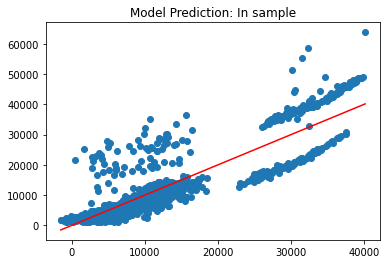

In [50]:
plt.scatter(lasso_pred_in, in_target)
plt.plot([min(lasso_pred_in), max(lasso_pred_in)], [min(lasso_pred_in), max(lasso_pred_in)], c = 'red')
plt.title('Model Prediction: In sample')

In [51]:
from sklearn.metrics import mean_squared_error
MSE_in = mean_squared_error(in_target,lasso_pred_in)
MSE_out = mean_squared_error(out_target,lasso_pred_out)

In [52]:
print('In sample MSE: ', MSE_in)
print('Out of sample MSE: ', MSE_out)

In sample MSE:  36490415.101693384
Out of sample MSE:  37252730.724018715
